In [1]:
#Copy the code and change the name for other artists
artist_name = "Koffee"

In [2]:
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import re

In [3]:
#Machine learning libraries for Text analysis
import nltk  # machine learning with text
from nltk import download as nltk_download
from nltk.corpus import stopwords, wordnet  # List of common words
from nltk.tokenize import word_tokenize  # Split text into significant forms
from nltk.stem import WordNetLemmatizer  # Reduce words to their root form
from nltk import pos_tag  # Tag words with parts of speech
from collections import defaultdict, Counter  # Dictionaries that have a backup value
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices
from textblob import TextBlob  # Sentiment analysis
from gensim.models.ldamodel import LdaModel  # Topic extraction
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # ngrams
from gensim.models.phrases import Phraser  # ngrams
from gensim import corpora, models, similarities  # Vectorization
import pyLDAvis
from wordcloud import WordCloud  # Create wordclouds
import matplotlib.pylab as plt

# Run next 2 cells only if you want to pull data from Genius

In [ ]:
from lyricsgenius import Genius

genius = Genius('JOSfSO0Cn0Y3avlw_ItRLdmwFj3s-36fjS-POUolMGFiWkUiE_zHXfQZVsOOqbxA', timeout=10)
artist = genius.search_artist(artist_name, max_songs = 300) # use max_songs=10 parameter to limit to 10 songs

In [ ]:
artist_json = artist.save_lyrics()

# Start here to use the data from the file on disk

In [4]:
#load the file
name_string = artist_name.replace(' ', '')
lyricsFile = "Lyrics_"+str(name_string)+".json"
with open(lyricsFile) as json_data:
    data = json.load(json_data)

# convert to dataframe
df = pd.DataFrame(data['songs'])
artist_df = df[['full_title', 'title', 'artist', 'lyrics', 'featured_artists', 'release_date']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Lyric Analysis

## Cleaning the lyrics

In [5]:
# convert everything to lower case
artist_df.lyrics = artist_df.lyrics.str.lower()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"[intro]\nkoffee come in like a rapture\n\n[chorus]\nkoffee come in like a rapture\nand everybody get capture\nplace lift up like helicopter\nwhen dem see di lyrics contractor\nkoffee come in like a rapture\nand everybody get capture\nplace lift up like helicopter, ayy\nwhen dem see di lyrical doctor\n\n[verse 1]\nkoffee hottin' up di temperature, fi dem see\nmi know dem envy but friend mi fi end mi\nyo a first mi see people deh round me so plenty\nbut mi pocket nuh empty, mi need space, oh lord, yeah, me\nsee dem a watch me through a crack now\na mussi true me have di ting pon lock down\nsitting ina di bentley, pickiny a di century\nyuh drench mi but fi mi fiyah gon blaze\nand a same way suh mi see di enemy a protest (oh)\nand him couldn't come di closest (no)\na koffee still a do the mostest\na wah me do put in the work and trust di process\noh yes, a so we grind right now\nkoffee wid di, koffee wid di prime time flow\ntime fi we accumulate di coins i know\nand me seh jah gimme di, j

In [7]:
# remove the embed, share, copy at the end of each lyric
artist_df.lyrics = artist_df.lyrics.replace(to_replace="embedshare url:copyembed:copy", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Remove quotes
artist_df.lyrics = artist_df.lyrics.replace(to_replace="(\u2019)", value="'", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# convert common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="won’t", value="will not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wouldn’t", value="wouldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="couldn’t", value="couldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="can’t", value="can not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="don’t", value="dont", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wanna", value="want to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="ain't", value="aint", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gotta", value="got to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gimme", value="give me", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'ll", value=" will", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="lil'", value="little", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="hol'", value="hold", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# convert more common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="it's", value="it is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i've", value="i have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'm", value="i am", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="n' ", value="ng ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'n ", value="ing ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=" 'em ", value="them ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="&", value="and", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# specific conversions for Koffee
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="mi", value="me", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="di", value="the", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="dem", value="them", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="dey", value="they", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="deh", value="the", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="wid", value="with", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="fi", value="for", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="pon", value="on", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="haffi", value="have to", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace=r"cyaa|cya", value="see you", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="ting", value="thing", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="nuh", value="not", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="yuh", value="you", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="weh", value="we", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="tek", value="take", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="dolla", value="dollar", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="gwaan", value="go on", regex=True)
artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace=r"inna|ina", value="in a", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-4a2660fa9b19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['lyrics'] = artist_df['lyrics'].replace(to_replace="mi", value="me", regex=True)
<ipython-input-11-4a2660fa9b19>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [12]:
artist_df.lyrics[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'[intro]\nsee you bawl in a life man\ngo on with it, me go on with it\nyo izy, are you kidtheng me?\n\n[pre-chorus]\ntoast (yeah, yeah)\nsay we a come in with a force (yeah)\nblessings we a reap on we course in a handful\nwe not rise and boast\nyeah, we give thanks like we need it the most\nwe haffor give thanks like we really supposed to, be thankful\n\n[chorus]\nblessings all on me life and\nme thank god for the journey, the earnings a jus for the plus (yeah)\ngratitude is a must (yeah)\nme see blessings fall by me right hand\nbuss a toast for the friends we take off heavy load\none time thed siddung in a class and we bored\nthen oli say do road and me go on with the road\n\n[verse 1]\nthird form, me say mek me try a thing\nand you know it formed out to be a forre thing\nnow a on stage with chronixx i a sing\nyeah you zimme, all theggy soon gi the i a ring\nlike "hello proto", him seh "had to shout you\nsaw you post a spectacular photo\nkeep it burning, yes, that\'s the motto\nif me 

In [13]:
# Remove common interjections, or singing sounds
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"aah|aagh|ayy|ooh|oo|oh", value="", regex=True) 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"hmm|mmm|brr", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"yeah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"woah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"uh", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"ye", value="", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# remove verse, chorus, bridge, intro , outro anotations 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\[[^]]*\]", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# get rid of tabs, new line, return symbols and parentheses
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=" ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\(|\)", ""], value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
artist_df.lyrics[10]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


" oluwaburna, ehn-ehn,           , ehn-ehn,            ,          , ehn-ehn,             this one na gbedu wey they ja pata me, i no get time, i they da pada dada cover my face, calling me lagbaja biggie man, wey no they wear agbada ahn ahn   my bredda, what's it gong be? g-wagon or de bentley? the gyalthem ritheng with me i no fort, thee for nothing my bredda, what's it gong be g-wagon or de bentley the gyalthem ritheng with me i no fort, thee for nothing   ahn, make you know say anything wey you do, them must commentate... so anything wey i they do i they try to they do am my way... plenty plenty plenty suffer wey we face just to make sure money they for my people, they gong say   but my people them go say i no want kpai, i no want thee i no want kpeme, i want enjoy i want chop life, i want buy motor i want build house, i still want turn up tell me, tell me   my bredda, what's it gong be? g-wagon or de bentley? the gyalthem ritheng with me i no fort, thee for nothing my bredda, what'

In [17]:
# remove any other symbols except letters, numbers and underscore
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\W", value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' koffee come in like a rapture   koffee come in like a rapture and everybody get capture place lift up like helicopter when them see the lyrics contractor koffee come in like a rapture and everybody get capture place lift up like helicopter   when them see the lyrical doctor   koffee hotthing up the temperature  for them see me know them envy but friend me for end me yo a forrst me see people the round me so plenty but me pocket not empty  me need space   lord    me see them a watch me through a crack now a mussi true me have the thing on lock down sitthing in a the bentley  pickiny a the century you drench me but for me foryah gon blaze and a same way s me see the enemy a protest    and him couldn t come the closest  no  a koffee still a do the mostest a wah me do put in the work and trust the process  s  a so we grind right now koffee with the  koffee with the prime time flow time for we accumulate the coins i know and me seh jah give me the  jah give me the signs like    koffee com

In [19]:
artist_df_clean = artist_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Tokenize
artist_df.lyrics = artist_df.lyrics.apply(word_tokenize)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['koffee',
 'come',
 'in',
 'like',
 'a',
 'rapture',
 'koffee',
 'come',
 'in',
 'like',
 'a',
 'rapture',
 'and',
 'everybody',
 'get',
 'capture',
 'place',
 'lift',
 'up',
 'like',
 'helicopter',
 'when',
 'them',
 'see',
 'the',
 'lyrics',
 'contractor',
 'koffee',
 'come',
 'in',
 'like',
 'a',
 'rapture',
 'and',
 'everybody',
 'get',
 'capture',
 'place',
 'lift',
 'up',
 'like',
 'helicopter',
 'when',
 'them',
 'see',
 'the',
 'lyrical',
 'doctor',
 'koffee',
 'hotthing',
 'up',
 'the',
 'temperature',
 'for',
 'them',
 'see',
 'me',
 'know',
 'them',
 'envy',
 'but',
 'friend',
 'me',
 'for',
 'end',
 'me',
 'yo',
 'a',
 'forrst',
 'me',
 'see',
 'people',
 'the',
 'round',
 'me',
 'so',
 'plenty',
 'but',
 'me',
 'pocket',
 'not',
 'empty',
 'me',
 'need',
 'space',
 'lord',
 'me',
 'see',
 'them',
 'a',
 'watch',
 'me',
 'through',
 'a',
 'crack',
 'now',
 'a',
 'mussi',
 'true',
 'me',
 'have',
 'the',
 'thing',
 'on',
 'lock',
 'down',
 'sitthing',
 'in',
 'a',
 'the',
 

## Analysis: common 2 and 3 word phrases found in the lyrics

In [22]:
# Divide the lyrics into "sentences" so that the phrases don't straddle songs.   Each song = one sentence
sentences = []
for l in artist_df.lyrics:
    sentences.append(l)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Number of sentences should equal the number of songs
len(sentences)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


16

In [24]:
# check our result on the first sentence
sentences[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['see',
 'you',
 'bawl',
 'in',
 'a',
 'life',
 'man',
 'go',
 'on',
 'with',
 'it',
 'me',
 'go',
 'on',
 'with',
 'it',
 'yo',
 'izy',
 'are',
 'you',
 'kidtheng',
 'me',
 'toast',
 'say',
 'we',
 'a',
 'come',
 'in',
 'with',
 'a',
 'force',
 'blessings',
 'we',
 'a',
 'reap',
 'on',
 'we',
 'course',
 'in',
 'a',
 'handful',
 'we',
 'not',
 'rise',
 'and',
 'boast',
 'we',
 'give',
 'thanks',
 'like',
 'we',
 'need',
 'it',
 'the',
 'most',
 'we',
 'haffor',
 'give',
 'thanks',
 'like',
 'we',
 'really',
 'supposed',
 'to',
 'be',
 'thankful',
 'blessings',
 'all',
 'on',
 'me',
 'life',
 'and',
 'me',
 'thank',
 'god',
 'for',
 'the',
 'journey',
 'the',
 'earnings',
 'a',
 'jus',
 'for',
 'the',
 'plus',
 'gratitude',
 'is',
 'a',
 'must',
 'me',
 'see',
 'blessings',
 'fall',
 'by',
 'me',
 'right',
 'hand',
 'buss',
 'a',
 'toast',
 'for',
 'the',
 'friends',
 'we',
 'take',
 'off',
 'heavy',
 'load',
 'one',
 'time',
 'thed',
 'siddung',
 'in',
 'a',
 'class',
 'and',
 'we',
 

In [25]:
# Look for frequently used 2 word combinations
from itertools import groupby

# Build the bigram model
bigram = Phrases(sentences)


# Find bigrams in the songs
two_word_phrases = []
i=0
while i < len(sentences): 
    bigrams = bigram[sentences[i]]
    for s in bigrams:
        if len(re.findall('_', s)) > 0:
            two_word_phrases.append(s)
    i = i + 1
two_word_phrases_df = pd.DataFrame(two_word_phrases, columns = ['Phrases'])
test = two_word_phrases_df.groupby(by = "Phrases").size().reset_index(name='counts')
test.sort_values(by = 'counts', ascending = False).head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
52,pressure_under,30
37,morning_in,29
56,tell_them,24
33,koffee_come,23
51,pressure_my,20


In [26]:
# Looking for 3 word combinations 

# Build the trigram models
trigram = Phrases(bigram[sentences])

tri = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = trigram[bigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 1:
            tri.append(s)
    i = i + 1

tri_df = pd.DataFrame(tri, columns = ['Phrases'])
test_tri = tri_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_tri.sort_values(by = 'counts', ascending = False).head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
18,koffee_come_in,15
35,thank_god_for,12
30,rapture_and_everybody,11
15,it_haffor_be,10
13,heart_enot_but_do,10
28,pressure_my_friend,10
27,pr_trouble_take,10
32,see_blessings_fall,10
1,better_not_haffor_live,10
16,it_not_settle,10


In [27]:
fourgram = Phrases(trigram[sentences])
four = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = fourgram[trigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 2:
            four.append(s)
    i = i + 1
    
four_df = pd.DataFrame(four, columns = ['Phrases'])
test_four = four_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_four.sort_values(by = 'counts', ascending = False).head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
0,better_not_haffor_live,10
1,but_do_no_mek,10
2,ghetto_for_be_under,10
3,nah_no_time_for,8


In [28]:
len(set(tri))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


42

In [29]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrases_df = pd.DataFrame(columns = ['phrase', 'score'])
phrase_col = []
score_col = []
wordcount_col = []
for phrase, score in phrases.find_phrases(sentences).items():
    phrase_col.append(phrase)
    score_col.append(score)
    wordcount_col.append(len(re.findall('_', phrase)) + 1)   
phrases_df['phrase'] = phrase_col
phrases_df['score'] = score_col
phrases_df['wordcount'] = wordcount_col
phrases_df[phrases_df['wordcount'] > 2].sort_values(by='wordcount', ascending = False).head(50)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,phrase,score,wordcount
46,queen_the_on_the_throne,185.777778,5
4,jus_for_the_plus,104.500000,4
71,morning_in_a_morning,59.921053,4
3,journey_the_earnings,156.750000,3
8,buss_a_toast,57.000000,3
14,class_and_we,10.649682,3
23,time_for_spend,40.307143,3
27,like_a_rapture,30.461538,3
35,come_in_like,14.310228,3
47,are_the_fyah,10.687500,3


In [30]:
from nltk import ngrams
tgs = nltk.ngrams(sentences[0],5)
fdist = nltk.FreqDist(tgs)
d = Counter()
ngrams_df = pd.DataFrame(columns = ['N-gram', 'Count'])
ngrams_col = []
Count_col = []
for k, v in fdist.items():
    d[k] = v
    ngrams_col.append(k)
    Count_col.append(v)
ngrams_df['N-gram'] = ngrams_col
ngrams_df['Count'] = Count_col
ngrams_df.sort_values(by='Count', ascending = False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,N-gram,Count
90,"(see, blessings, fall, by, me)",4
105,"(off, heavy, load, one, time)",4
103,"(we, take, off, heavy, load)",4
102,"(friends, we, take, off, heavy)",4
101,"(the, friends, we, take, off)",4
100,"(for, the, friends, we, take)",4
98,"(a, toast, for, the, friends)",4
97,"(buss, a, toast, for, the)",4
96,"(hand, buss, a, toast, for)",4
95,"(right, hand, buss, a, toast)",4


In [31]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     [see, you, bawl, in, a, life, man, go, on, wit...
1     [yo, izy, are, you, kidtheng, me, a, no, news,...
2     [koffee, come, in, like, a, rapture, koffee, c...
3     [where, will, we, go, when, the, quarantine, t...
4     [mm, frankie, music, frankie, raggamufforn, re...
5     [come, with, the, fyah, come, with, the, fyah,...
6     [genna, genna, koffee, come, in, like, a, rapt...
7     [now, me, the, on, the, go, now, tell, them, w...
8     [put, the, flame, to, the, theesel, ketch, a, ...
9     [never, give, up, never, give, in, under, the,...
10    [oluwaburna, ehn, ehn, ehn, ehn, ehn, ehn, thi...
11    [hear, dat, them, think, it, is, a, joke, sist...
12    [see, you, bawl, in, a, life, man, go, on, wit...
13    [in, a, morning, in, a, morning, in, a, mornin...
14    [blessings, fall, by, me, right, hand, me, tha...
15    [turn, it, up, buss, bars, toddla, t, producky...
Name: lyrics, dtype: object

In [32]:
stop_words = stopwords.words("english")
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in stop_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     [see, bawl, life, man, go, go, yo, izy, kidthe...
1     [yo, izy, kidtheng, news, prime, crime, dollar...
2     [koffee, come, like, rapture, koffee, come, li...
3     [go, quarantine, thing, done, everybody, touch...
4     [mm, frankie, music, frankie, raggamufforn, re...
5     [come, fyah, come, fyah, city, burning, jus, t...
6     [genna, genna, koffee, come, like, rapture, h,...
7     [go, tell, watch, trafforc, koffee, slow, zone...
8     [put, flame, theesel, ketch, fyah, mek, burn, ...
9     [never, give, never, give, pressure, pressure,...
10    [oluwaburna, ehn, ehn, ehn, ehn, ehn, ehn, one...
11    [hear, dat, think, joke, sister, talk, real, n...
12    [see, bawl, life, man, go, go, toast, say, com...
13    [morning, morning, morning, morning, go, tell,...
14    [blessings, fall, right, hand, thank, god, jou...
15    [turn, buss, bars, toddla, producky, koffee, c...
Name: lyrics, dtype: object

In [34]:
lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Perform the lemmatization
#artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])#
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
remove_words = ['like', 'get', 'got', 'know', 'say']
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in remove_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
artist_df.lyrics[10]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['oluwaburna',
 'ehn',
 'ehn',
 'ehn',
 'ehn',
 'ehn',
 'ehn',
 'one',
 'na',
 'gbedu',
 'wey',
 'ja',
 'pata',
 'time',
 'da',
 'pada',
 'dada',
 'cover',
 'face',
 'call',
 'lagbaja',
 'biggie',
 'man',
 'wey',
 'wear',
 'agbada',
 'ahn',
 'ahn',
 'bredda',
 'gong',
 'g',
 'wagon',
 'de',
 'bentley',
 'gyalthem',
 'ritheng',
 'fort',
 'thee',
 'nothing',
 'bredda',
 'gong',
 'g',
 'wagon',
 'de',
 'bentley',
 'gyalthem',
 'ritheng',
 'fort',
 'thee',
 'nothing',
 'ahn',
 'make',
 'anything',
 'wey',
 'must',
 'commentate',
 'anything',
 'wey',
 'try',
 'way',
 'plenty',
 'plenty',
 'plenty',
 'suffer',
 'wey',
 'face',
 'make',
 'sure',
 'money',
 'people',
 'gong',
 'people',
 'go',
 'want',
 'kpai',
 'want',
 'thee',
 'want',
 'kpeme',
 'want',
 'enjoy',
 'want',
 'chop',
 'life',
 'want',
 'buy',
 'motor',
 'want',
 'build',
 'house',
 'still',
 'want',
 'turn',
 'tell',
 'tell',
 'bredda',
 'gong',
 'g',
 'wagon',
 'de',
 'bentley',
 'gyalthem',
 'ritheng',
 'fort',
 'thee',
 'no

In [37]:
# Create the list of words and their frequency (corpus)
from gensim import corpora
pyLDAvis.enable_notebook()
#dictionary = corpora.Dictionary(artist_df.lyrics )
dictionary = corpora.Dictionary(artist_df.lyrics)
corpus = [dictionary.doc2bow(text) for text in artist_df.lyrics ]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
import gensim
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.064*"pressure" + 0.026*"feel" + 0.023*"haffor" + 0.022*"cause" + 0.020*"friend" + 0.017*"well" + 0.016*"heart" + 0.014*"take" + 0.013*"mek" + 0.012*"see"')
(1, '0.025*"see" + 0.021*"morning" + 0.015*"koffee" + 0.015*"go" + 0.014*"seh" + 0.012*"tell" + 0.012*"time" + 0.010*"come" + 0.008*"burn" + 0.008*"nah"')
(2, '0.023*"see" + 0.022*"koffee" + 0.019*"come" + 0.018*"blessing" + 0.013*"toast" + 0.012*"go" + 0.011*"jah" + 0.011*"fyah" + 0.011*"rapture" + 0.010*"right"')


In [39]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
dictionary

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

#sentences = Text8Corpus(datapath('testcorpus.txt'))
artist_df.lyrics1 = [wd for wd in artist_df.lyrics]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(artist_df.lyrics1, min_count=3, threshold=10)

# Construct bigram
print(bigram[artist_df.lyrics[0]])

['see_bawl', 'life_man', 'go', 'go', 'yo', 'izy', 'kidtheng', 'toast', 'come', 'force', 'blessing', 'reap', 'course', 'handful', 'rise_boast', 'give_thanks', 'need', 'haffor', 'give_thanks', 'really_suppose', 'thankful', 'blessing_life', 'thank_god', 'journey_earnings', 'jus_plus', 'gratitude_must', 'see', 'blessing_fall', 'right_hand', 'bus_toast', 'friend_take', 'heavy_load', 'one_time', 'thed_siddung', 'class_bore', 'oli_road', 'go_road', 'third', 'form', 'mek', 'try', 'thing', 'form', 'forre', 'thing', 'stage', 'chronixx', 'sing', 'zimme', 'theggy', 'sn', 'gi', 'ring', 'hello', 'proto', 'seh', 'shout', 'saw', 'post', 'spectacular', 'photo', 'keep_burning', 'motto', 'bout', 'pas', 'show', 'see_bawl', 'life_man', 'haffor', 'thank_god', 'journey_earnings', 'jus_plus', 'gratitude_must', 'see', 'blessing_fall', 'right_hand', 'bus_toast', 'friend_take', 'heavy_load', 'one_time', 'thed_siddung', 'class_bore', 'oli_road', 'gwan', 'go', 'jah_shower', 'blessing_uon', 'tell_story', 'jah_showe

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-41-00f6d1d42edf>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  artist_df.lyrics1 = [wd for wd in artist_df.lyrics]


# Wordcloud

In [42]:
artist_df.lyrics = artist_df.lyrics.apply(lambda x: " ".join(x))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [43]:
artist_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date
0,Toast by Koffee,Toast,Koffee,see bawl life man go go yo izy kidtheng toast ...,[],2018-11-15
1,W by Koffee (Ft. Gunna),W,Koffee,yo izy kidtheng news prime crime dollar sign m...,"[{'api_path': '/artists/91049', 'header_image_...",2019-11-26
2,Rapture by Koffee,Rapture,Koffee,koffee come rapture koffee come rapture everyb...,[],2019-03-14
3,Lockdown by Koffee,Lockdown,Koffee,go quarantine thing do everybody touch road mo...,[],2020-07-17
4,Raggamuffin by Koffee,Raggamuffin,Koffee,mm frankie music frankie raggamufforn reggae b...,[],2018-01-19


In [44]:
# Create an object that converts strings into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 20000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

data_dtm = vectorizer.fit_transform(artist_df.lyrics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Create a dataframe of terms and frequencies
# Get the frequency of each term

term_frequencies = data_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term","frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


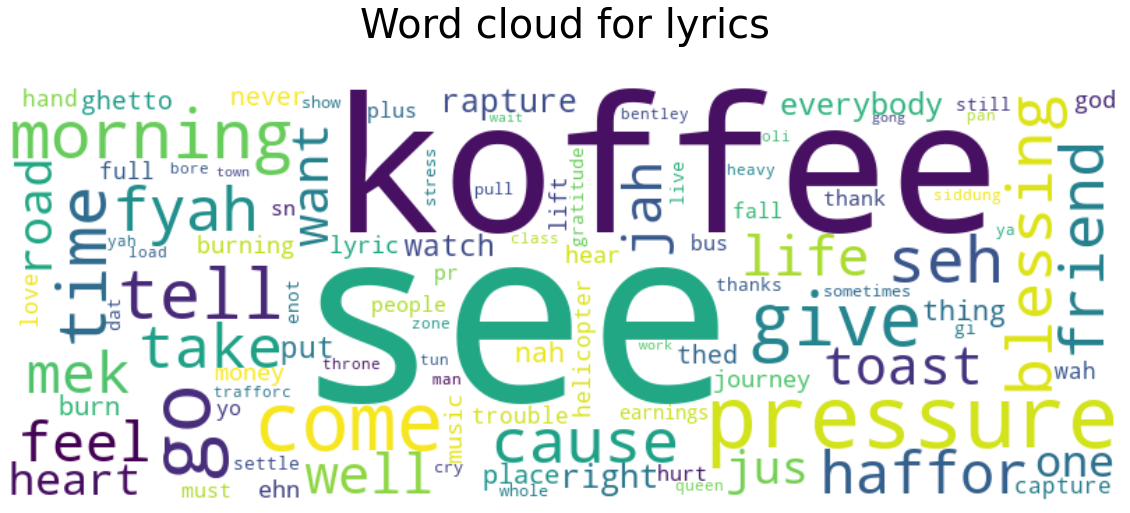

In [46]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment

In [47]:
# Assign sentiment to each lyric
artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-47-d312c35c4e1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)


In [48]:
artist_df.sort_values(by="sentiment", ascending=False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date,sentiment
10,Ye (BBC 1Xtra Cover) by Koffee,Ye (BBC 1Xtra Cover),Koffee,oluwaburna ehn ehn ehn ehn ehn ehn one na gbed...,[],2019-04-03,0.375000
8,Blazin by Koffee (Ft. Jane Macgizmo),Blazin,Koffee,put flame theesel ketch fyah mek burn prar any...,"[{'api_path': '/artists/1190812', 'header_imag...",2019-03-14,0.297829
14,Toast (Clipz Bootleg) by Koffee,Toast (Clipz Bootleg),Koffee,blessing fall right hand thank god journey ear...,[],2020-03-04,0.275325
1,W by Koffee (Ft. Gunna),W,Koffee,yo izy kidtheng news prime crime dollar sign m...,"[{'api_path': '/artists/91049', 'header_image_...",2019-11-26,0.263301
6,Rapture (Remix) by Koffee (Ft. Govana),Rapture (Remix),Koffee,genna genna koffee come rapture h h de lassana...,"[{'api_path': '/artists/988660', 'header_image...",2019-05-31,0.205864
15,Buss Bars (Freestyle) by Koffee,Buss Bars (Freestyle),Koffee,turn bus bar toddla producky koffee come raptu...,[],None,0.180952
0,Toast by Koffee,Toast,Koffee,see bawl life man go go yo izy kidtheng toast ...,[],2018-11-15,0.170677
2,Rapture by Koffee,Rapture,Koffee,koffee come rapture koffee come rapture everyb...,[],2019-03-14,0.167440
12,Toast (Mura Masa Remix) by Koffee,Toast (Mura Masa Remix),Koffee,see bawl life man go go toast come force bless...,[],2019-06-25,0.155714
5,Burning by Koffee,Burning,Koffee,come fyah come fyah city burning jus tun high ...,[],2017-10-19,0.122281


In [49]:
artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")
artist_df = artist_df.sort_values(by = "Datetime")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-20a3b369a7a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


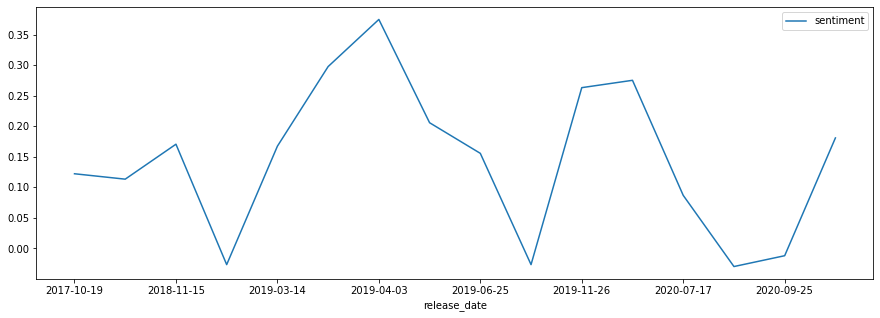

In [50]:
plt = artist_df.plot(x = 'release_date', y = 'sentiment', figsize=(15, 5))